In [156]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier,plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score


from imblearn.over_sampling import ADASYN,SMOTE
%matplotlib inline


pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

In [58]:
# TO run once to upload file to colab
from google.colab import files
#uploaded = files.upload()

In [59]:
df = pd.read_csv('insurance_claims.csv')

# Data Cleaning

In [60]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [61]:
# missing value check

missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)


,feature,unique_values,percent_missing,percent_biggest_cat,type
0,months_as_customer,391,0.0,0.8,int64
29,witnesses,4,0.0,25.8,int64
22,incident_state,7,0.0,26.2,object
23,incident_city,7,0.0,15.7,object
24,incident_location,1000,0.0,0.1,object
25,incident_hour_of_the_day,24,0.0,5.4,int64
26,number_of_vehicles_involved,4,0.0,58.1,int64
27,property_damage,3,0.0,36.0,object
28,bodily_injuries,3,0.0,34.0,int64
30,police_report_available,3,0.0,34.3,object


In [62]:
categorical_cols = df.select_dtypes(include=["object"]).columns
print(categorical_cols)
display(df[categorical_cols])

Index(['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'incident_date', 'incident_type',
       'collision_type', 'incident_severity', 'authorities_contacted',
       'incident_state', 'incident_city', 'incident_location',
       'property_damage', 'police_report_available', 'auto_make', 'auto_model',
       'fraud_reported'],
      dtype='object')


,policy_bind_date,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,property_damage,police_report_available,auto_make,auto_model,fraud_reported
0,2014-10-17,OH,250/500,MALE,MD,craft-repair,sleeping,husband,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,YES,YES,Saab,92x,Y
1,2006-06-27,IN,250/500,MALE,MD,machine-op-inspct,reading,other-relative,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,?,?,Mercedes,E400,Y
2,2000-09-06,OH,100/300,FEMALE,PhD,sales,board-games,own-child,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,NO,NO,Dodge,RAM,N
3,1990-05-25,IL,250/500,FEMALE,PhD,armed-forces,board-games,unmarried,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,?,NO,Chevrolet,Tahoe,Y
4,2014-06-06,IL,500/1000,MALE,Associate,sales,board-games,unmarried,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,NO,NO,Accura,RSX,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1991-07-16,OH,500/1000,FEMALE,Masters,craft-repair,paintball,unmarried,2015-02-22,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,6045 Andromedia St,YES,?,Honda,Accord,N
996,2014-01-05,IL,100/300,FEMALE,PhD,prof-specialty,sleeping,wife,2015-01-24,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,3092 Texas Drive,YES,?,Volkswagen,Passat,N
997,2003-02-17,OH,250/500,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,2015-01-23,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,7629 5th St,?,YES,Suburu,Impreza,N
998,2011-11-18,IL,500/1000,MALE,Associate,handlers-cleaners,base-jumping,wife,2015-02-26,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,6128 Elm Lane,?,YES,Audi,A5,N


In [63]:
#extract out the year as 

df['policy_bind_year']=df['policy_bind_date'].str.extract('(\d{4})\-').astype('int64')

In [64]:
#extract the month out 
#all accidents are from 2015 jan and feb, so year isnt very important

df['incident_month']=df['incident_date'].str.extract('\d{4}\-(\d{2})').astype('int64')

In [65]:
#replace "?" with undocumented 

df['collision_type'] = df['collision_type'].replace("?", "undocumented")
df['police_report_available'] = df['police_report_available'].replace("?", "undocumented")
df['property_damage'] = df['property_damage'].replace("?", "undocumented")
df['auto_make'] = df['auto_make'].replace("Suburu", "Subaru")

In [66]:
#incident_severity can be seen as ordinal
#code them in order of severity 

df['incident_severity'] = df['incident_severity'].map({"Trivial Damage":0,
                                                       "Minor Damage":1,
                                                       "Major Damage":2,
                                                       "Total Loss":3
                                                      }).astype("int64")
df.incident_severity.value_counts()

1    354
3    280
2    276
0     90
Name: incident_severity, dtype: int64

In [67]:
df['umbrella_limit'].sort_values(ascending=True)

290    -1000000
0             0
623           0
624           0
625           0
         ...   
657     9000000
458     9000000
975     9000000
430    10000000
115    10000000
Name: umbrella_limit, Length: 1000, dtype: int64

In [68]:
df[df['umbrella_limit']<0]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_bind_year,incident_month
290,284,42,526039,1995-05-04,OH,100/300,500,1338.54,-1000000,438178,MALE,Associate,machine-op-inspct,kayaking,wife,0,0,2015-01-29,Single Vehicle Collision,Side Collision,2,Ambulance,NC,Arlington,3936 Tree Drive,13,1,YES,0,1,undocumented,94160,8560,17120,68480,Chevrolet,Malibu,1996,N,1995,1


In [69]:
# Umbrella limit cannot be negative, it might be an error.
#edit to positve
df['umbrella_limit'].iloc[290] = 1000000

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [70]:
len(df.columns)

41

In [71]:
cont_var =['age','incident_hour_of_the_day',
           'number_of_vehicles_involved','total_claim_amount',
           'injury_claim','property_claim','vehicle_claim',
           'months_as_customer','policy_annual_premium','policy_deductable',
           'umbrella_limit','capital-gains','capital-loss', 
           'auto_year','witnesses','bodily_injuries','policy_bind_year','incident_severity']
df[cont_var]

,age,incident_hour_of_the_day,number_of_vehicles_involved,total_claim_amount,injury_claim,property_claim,vehicle_claim,months_as_customer,policy_annual_premium,policy_deductable,umbrella_limit,capital-gains,capital-loss,auto_year,witnesses,bodily_injuries,policy_bind_year,incident_severity
0,48,5,1,71610,6510,13020,52080,328,1406.91,1000,0,53300,0,2004,2,1,2014,2
1,42,8,1,5070,780,780,3510,228,1197.22,2000,5000000,0,0,2007,0,0,2006,1
2,29,7,3,34650,7700,3850,23100,134,1413.14,2000,5000000,35100,0,2007,3,2,2000,1
3,41,5,1,63400,6340,6340,50720,256,1415.74,2000,6000000,48900,-62400,2014,2,1,1990,2
4,44,20,1,6500,1300,650,4550,228,1583.91,1000,6000000,66000,-46000,2009,1,0,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,38,20,1,87200,17440,8720,61040,3,1310.80,1000,0,0,0,2006,1,0,1991,1
996,41,23,1,108480,18080,18080,72320,285,1436.79,1000,0,70900,0,2015,3,2,2014,2
997,34,4,3,67500,7500,7500,52500,130,1383.49,500,3000000,35100,0,1996,3,2,2003,1
998,62,2,1,46980,5220,5220,36540,458,1356.92,2000,5000000,0,0,1998,1,0,2011,2


In [72]:
ord_var = ['policy_deductable','witnesses','bodily_injuries','incident_severity']
df[ord_var]

,policy_deductable,witnesses,bodily_injuries,incident_severity
0,1000,2,1,2
1,2000,0,0,1
2,2000,3,2,1
3,2000,2,1,2
4,1000,1,0,1
...,...,...,...,...
995,1000,1,0,1
996,1000,3,2,2
997,500,3,2,1
998,2000,1,0,2


In [73]:
quan_var = (list(set(cont_var) - set(ord_var))) 
df[quan_var]

,age,number_of_vehicles_involved,capital-gains,umbrella_limit,policy_annual_premium,injury_claim,capital-loss,property_claim,vehicle_claim,auto_year,policy_bind_year,months_as_customer,incident_hour_of_the_day,total_claim_amount
0,48,1,53300,0,1406.91,6510,0,13020,52080,2004,2014,328,5,71610
1,42,1,0,5000000,1197.22,780,0,780,3510,2007,2006,228,8,5070
2,29,3,35100,5000000,1413.14,7700,0,3850,23100,2007,2000,134,7,34650
3,41,1,48900,6000000,1415.74,6340,-62400,6340,50720,2014,1990,256,5,63400
4,44,1,66000,6000000,1583.91,1300,-46000,650,4550,2009,2014,228,20,6500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,38,1,0,0,1310.80,17440,0,8720,61040,2006,1991,3,20,87200
996,41,1,70900,0,1436.79,18080,0,18080,72320,2015,2014,285,23,108480
997,34,3,35100,3000000,1383.49,7500,0,7500,52500,1996,2003,130,4,67500
998,62,1,0,5000000,1356.92,5220,0,5220,36540,1998,2011,458,2,46980


In [74]:
#Discrete variables
nom_var = (list(set(df.columns) - set(cont_var))) 
df[nom_var]

,policy_number,incident_type,insured_education_level,incident_city,insured_relationship,police_report_available,property_damage,authorities_contacted,incident_state,auto_model,incident_month,insured_zip,policy_state,insured_sex,policy_csl,incident_location,incident_date,insured_occupation,collision_type,fraud_reported,insured_hobbies,auto_make,policy_bind_date
0,521585,Single Vehicle Collision,MD,Columbus,husband,YES,YES,Police,SC,92x,1,466132,OH,MALE,250/500,9935 4th Drive,2015-01-25,craft-repair,Side Collision,Y,sleeping,Saab,2014-10-17
1,342868,Vehicle Theft,MD,Riverwood,other-relative,undocumented,undocumented,Police,VA,E400,1,468176,IN,MALE,250/500,6608 MLK Hwy,2015-01-21,machine-op-inspct,undocumented,Y,reading,Mercedes,2006-06-27
2,687698,Multi-vehicle Collision,PhD,Columbus,own-child,NO,NO,Police,NY,RAM,2,430632,OH,FEMALE,100/300,7121 Francis Lane,2015-02-22,sales,Rear Collision,N,board-games,Dodge,2000-09-06
3,227811,Single Vehicle Collision,PhD,Arlington,unmarried,NO,undocumented,Police,OH,Tahoe,1,608117,IL,FEMALE,250/500,6956 Maple Drive,2015-01-10,armed-forces,Front Collision,Y,board-games,Chevrolet,1990-05-25
4,367455,Vehicle Theft,Associate,Arlington,unmarried,NO,NO,None,NY,RSX,2,610706,IL,MALE,500/1000,3041 3rd Ave,2015-02-17,sales,undocumented,N,board-games,Accura,2014-06-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,941851,Single Vehicle Collision,Masters,Northbrook,unmarried,undocumented,YES,Fire,NC,Accord,2,431289,OH,FEMALE,500/1000,6045 Andromedia St,2015-02-22,craft-repair,Front Collision,N,paintball,Honda,1991-07-16
996,186934,Single Vehicle Collision,PhD,Northbend,wife,undocumented,YES,Fire,SC,Passat,1,608177,IL,FEMALE,100/300,3092 Texas Drive,2015-01-24,prof-specialty,Rear Collision,N,sleeping,Volkswagen,2014-01-05
997,918516,Multi-vehicle Collision,Masters,Arlington,other-relative,YES,undocumented,Police,NC,Impreza,1,442797,OH,FEMALE,250/500,7629 5th St,2015-01-23,armed-forces,Side Collision,N,bungie-jumping,Subaru,2003-02-17
998,533940,Single Vehicle Collision,Associate,Arlington,wife,YES,undocumented,Other,NY,A5,2,441714,IL,MALE,500/1000,6128 Elm Lane,2015-02-26,handlers-cleaners,Rear Collision,N,base-jumping,Audi,2011-11-18


In [75]:
#check for norminal data

def print_value_counts_cat(df):
  for col in df:
      print(col)
      print("======================")
      print(df[col].value_counts())
      print("---------------------------------------------")
      print("  ")
print_value_counts_cat(df[nom_var])

policy_number
116735    1
107181    1
430794    1
115399    1
328387    1
         ..
218456    1
179538    1
357713    1
247116    1
296960    1
Name: policy_number, Length: 1000, dtype: int64
---------------------------------------------
  
incident_type
Multi-vehicle Collision     419
Single Vehicle Collision    403
Vehicle Theft                94
Parked Car                   84
Name: incident_type, dtype: int64
---------------------------------------------
  
insured_education_level
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: insured_education_level, dtype: int64
---------------------------------------------
  
incident_city
Springfield    157
Arlington      152
Columbus       149
Northbend      145
Hillsdale      141
Riverwood      134
Northbrook     122
Name: incident_city, dtype: int64
---------------------------------------------
  
insured_relationship
own-child         183
other-rel

#### policy_bind_date,incident_date,incident_location,insured_zip,auto_model,policy_number have high number of categories, which may not be meaningful 

In [76]:
#drop these  variables from analysis 
large_cat=['policy_bind_date','incident_date','incident_location','insured_zip','auto_model','policy_number']
df.drop(large_cat, axis=1, inplace=True)

In [77]:
#redefine the norminal var
#remove dv from the list

nom_var.remove('fraud_reported')
nom_var = (list(set(nom_var) - set(large_cat))) 
len(nom_var)

16

In [78]:
print ('total var count:{}'.format(len(list(df.columns))),
       'continous var count:{}'.format(len(cont_var)),
       'norminal var count:{}'.format(len(nom_var)))

total var count:35 continous var count:18 norminal var count:16


# Exploratory Data Analysis

In [79]:
df.fraud_reported.value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

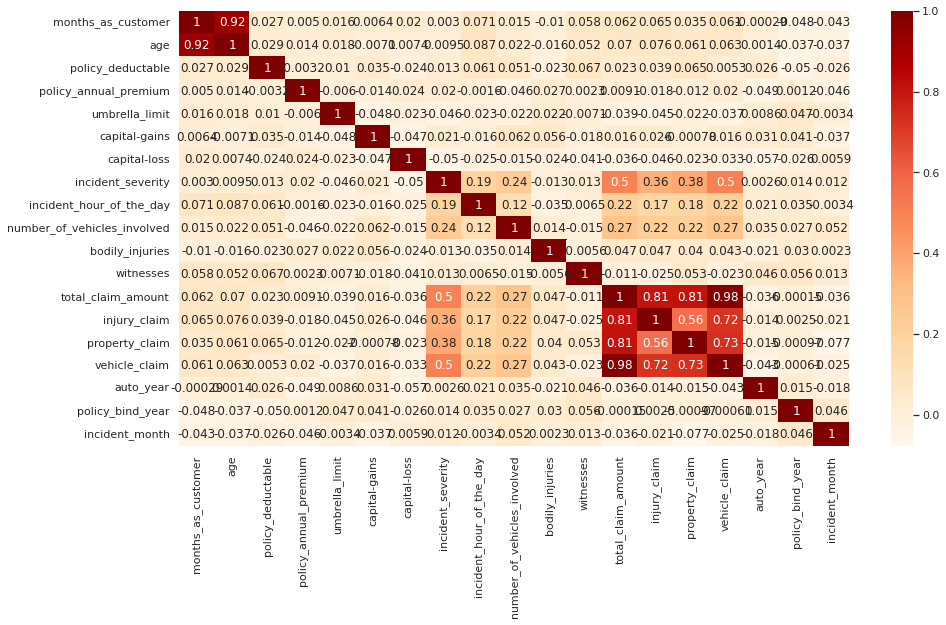

In [81]:
#Correlation among the variables
corr = df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, annot=True, cmap='OrRd')

1.   Total_claim_amount is sum of injury_claim, property_claim, vehicle_claim and can be dropped.
2.   age feature is highly correlated with months_as_customer and can be dropped




In [82]:
# Dropping age and total_claim_amount as it has very high correlation
df.drop(['age','total_claim_amount'], axis=1, inplace=True)

In [84]:
cont_var = (list(set(cont_var) - set(['age','total_claim_amount']))) 
len(cont_var)

16

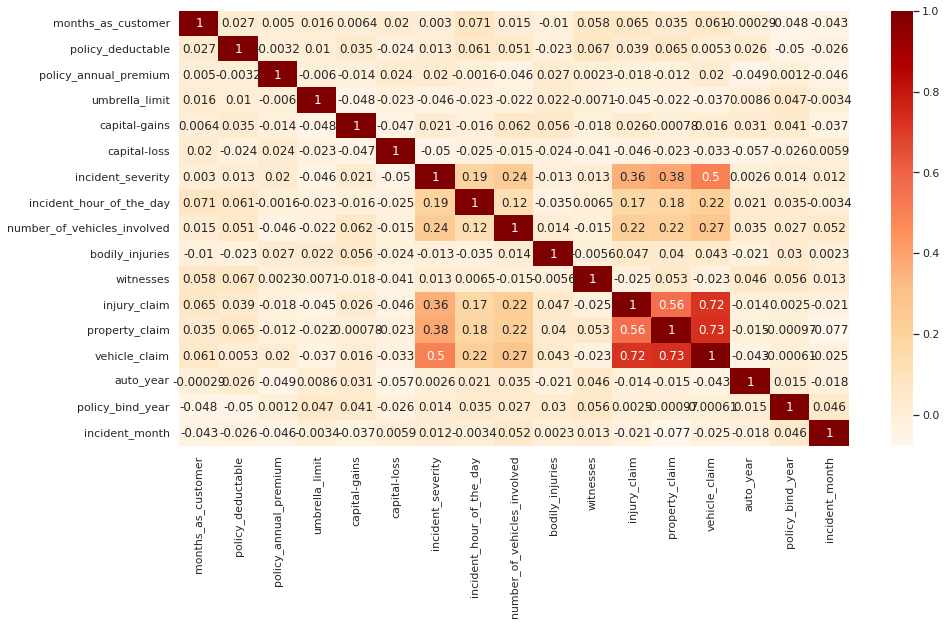

In [83]:
corr = df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, annot=True, cmap='OrRd')

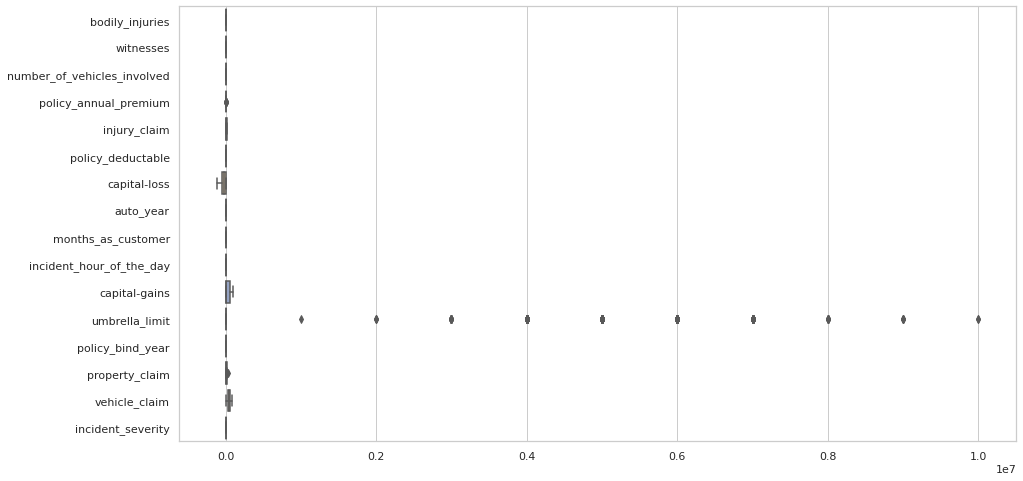

In [96]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=df[cont_var], orient="h", palette="Set2")

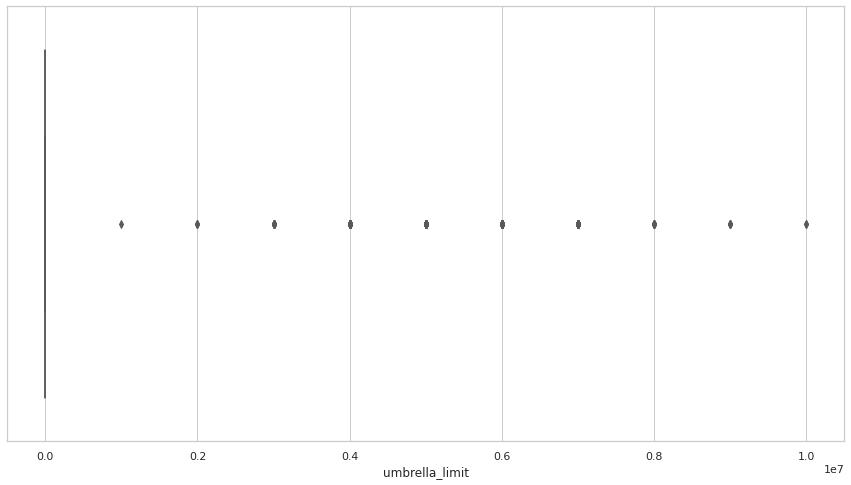

In [100]:
sns.boxplot(x='umbrella_limit', data=df[cont_var], orient="h", palette="Set2")

In [103]:
df['umbrella_limit'].describe()

count    1.000000e+03
mean     1.103000e+06
std      2.296446e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+07
Name: umbrella_limit, dtype: float64

In [112]:
# umbrella_limit feature has erroneous values, so dropping the feature
df.drop('umbrella_limit', axis=1, inplace=True)

In [113]:
cont_var = (list(set(cont_var) - set(['umbrella_limit']))) 
len(cont_var)

15

# Preprocessing

In [114]:
df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})
df['fraud_reported']

0      1
1      1
2      0
3      1
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: fraud_reported, Length: 1000, dtype: int64

In [115]:
df['insured_sex'] = df['insured_sex'].map({"FEMALE":0,"MALE":1})

In [116]:
#Capital loss is in negative.Making it positive
df['capital-loss']=df['capital-loss']*(-1)

In [117]:
df['capital-loss'].max()

111100

In [119]:
df.head()

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,policy_bind_year,incident_month
0,328,OH,250/500,1000,1406.91,1,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,2,Police,SC,Columbus,5,1,YES,1,2,YES,6510,13020,52080,Saab,2004,1,2014,1
1,228,IN,250/500,2000,1197.22,1,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,undocumented,1,Police,VA,Riverwood,8,1,undocumented,0,0,undocumented,780,780,3510,Mercedes,2007,1,2006,1
2,134,OH,100/300,2000,1413.14,0,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,1,Police,NY,Columbus,7,3,NO,2,3,NO,7700,3850,23100,Dodge,2007,0,2000,2
3,256,IL,250/500,2000,1415.74,0,PhD,armed-forces,board-games,unmarried,48900,62400,Single Vehicle Collision,Front Collision,2,Police,OH,Arlington,5,1,undocumented,1,2,NO,6340,6340,50720,Chevrolet,2014,1,1990,1
4,228,IL,500/1000,1000,1583.91,1,Associate,sales,board-games,unmarried,66000,46000,Vehicle Theft,undocumented,1,None,NY,Arlington,20,1,NO,0,1,NO,1300,650,4550,Accura,2009,0,2014,2


In [120]:

dum = pd.get_dummies(df[nom_var], drop_first=True)
dum.head()

,insured_sex,incident_month,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,property_damage_YES,property_damage_undocumented,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Rear Collision,collision_type_Side Collision,collision_type_undocumented,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,policy_state_IN,policy_state_OH,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,policy_csl_250/500,policy_csl_500/1000,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Subaru,auto_make_Toyota,auto_make_Volkswagen,police_report_available_YES,police_report_available_undocumented
0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [121]:
dum.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df_dummied = pd.concat([dum, df], axis=1)

In [122]:
df_dummied.drop(nom_var, axis=1, inplace=True)

In [123]:
df_dummied.head()

,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,property_damage_YES,property_damage_undocumented,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Rear Collision,collision_type_Side Collision,collision_type_undocumented,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,policy_state_IN,policy_state_OH,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_city_Columbus,incident_city_Hillsdale,incident_city_Northbend,incident_city_Northbrook,incident_city_Riverwood,incident_city_Springfield,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,insured_relationship_unmarried,insured_relationship_wife,policy_csl_250/500,policy_csl_500/1000,insured_hobbies_basketball,insured_hobbies_board-games,insured_hobbies_bungie-jumping,insured_hobbies_camping,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_dancing,insured_hobbies_exercise,insured_hobbies_golf,insured_hobbies_hiking,insured_hobbies_kayaking,insured_hobbies_movies,insured_hobbies_paintball,insured_hobbies_polo,insured_hobbies_reading,insured_hobbies_skydiving,insured_hobbies_sleeping,insured_hobbies_video-games,insured_hobbies_yachting,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Subaru,auto_make_Toyota,auto_make_Volkswagen,police_report_available_YES,police_report_available_undocumented,months_as_customer,policy_deductable,policy_annual_premium,capital-gains,capital-loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim,auto_year,fraud_reported,policy_bind_year
0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,328,1000,1406.91,53300,0,2,5,1,1,2,6510,13020,52080,2004,1,2014
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,228,2000,1197.22,0,0,1,8,1,0,0,780,780,3510,2007,1,2006
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,134,2000,1413.14,35100,0,1,7,3,2,3,7700,3850,23100,2007,0,2000
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,256,2000,1415.74,48900,62400,2,5,1,1,2,6340,6340,50720,2014,1,1990
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,228,1000,1583.91,66000,46000,1,20,1,0,1,1300,650,4550,2009,0,2014


### Test Train Split

In [124]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [125]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

# Modeling


we know that our dataset is biased. 
Modelling with class weighting and hyperparameter tuning

In [129]:
def get_scores(t, name):
  """
  This function help print all the metrics  
  """
  print (name, 'classification metric')
  print("CV scores:", round(t.best_score_,3))
  print("train score:", round(t.score(x_train, y_train),3))
  print("test score:", round(t.score(x_test, y_test),3))

  #Evaluation metrics
  predictions = t.best_estimator_.predict(x_test)

  TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

  sensi = TP/(TP + FN)
  speci= TN/(TN + FP)
  preci = TP/(TP + FP)
  f1= 2*(preci*sensi)/(preci+sensi)

  print(f'Sensitivity: {round(sensi,3)}')
  print(f'Specificity: {round(speci,3)}')
  print(f'Precision: {round(preci,3)}')
  print(f'F1: {round(f1,3)}')

  pred_proba = [i[1] for i in t.predict_proba(x_test)]
  auc_score = roc_auc_score(y_test, pred_proba)
  print('ROC AUC Score:', round(auc_score,3))

#### Logistic Regression

In [127]:
y_train.value_counts(normalize=True)

0    0.753333
1    0.246667
Name: fraud_reported, dtype: float64

In [132]:

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

    
rs_lr = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr.fit(x_train, y_train, )
print(rs_lr.best_params_)
get_scores(rs_lr,'Logistic regression')

{'solver': 'liblinear', 'penalty': 'l1', 'class_weight': None, 'C': 910.2981779915227}
Logistic regression classification metric
CV scores: 0.771
train score: 0.84
test score: 0.728
Sensitivity: 0.339
Specificity: 0.856
Precision: 0.438
F1: 0.382
ROC AUC Score: 0.649


#### Random Forest

In [133]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None]
              }

    
rs_rf = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf.fit(x_train, y_train)
print(rs_rf.best_params_)
get_scores(rs_rf,'Random forest')

{'n_estimators': 350, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'class_weight': {0: 0.246667, 1: 0.75333}}
Random forest classification metric
CV scores: 0.813
train score: 0.961
test score: 0.784
Sensitivity: 0.5
Specificity: 0.878
Precision: 0.574
F1: 0.534
ROC AUC Score: 0.797


#### XGBoost

In [134]:
#scale_pos_weight = total_negative_examples / total_positive_examples
y_train.value_counts()[0]/y_train.value_counts()[1]

3.054054054054054

In [135]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'scale_pos_weight':[1, 3.054054054054054],
              }
    
rs_xg = RandomizedSearchCV(xg, xg_values, cv=10, n_jobs = -1, random_state=42)
rs_xg.fit(x_train, y_train)
print(rs_xg.best_params_)

{'scale_pos_weight': 3.054054054054054, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 550, 'max_depth': 6, 'gamma': 3, 'eta': 0.05}


In [136]:
get_scores(rs_xg,'XGBoost')

XGBoost classification metric
CV scores: 0.848
train score: 0.961
test score: 0.836
Sensitivity: 0.79
Specificity: 0.851
Precision: 0.636
F1: 0.705
ROC AUC Score: 0.833


Lets balance the data by using SMOTE

1    565
0    565
Name: fraud_reported, dtype: int64


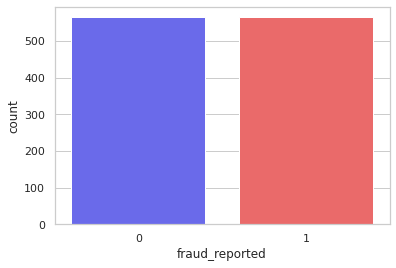

In [139]:
#SMOTE data for train set

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
print(y_train.value_counts())

sns.countplot(x=y_train, palette='seismic');

#### Logistic regression

In [140]:
lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            }
   
rs_lr2 = RandomizedSearchCV(lr, lr_values, cv=10, n_jobs = -1, random_state=42)
rs_lr2.fit(x_train, y_train)
print(rs_lr2.best_params_)
get_scores(rs_lr2,'Logistic regression 2')

{'solver': 'liblinear', 'penalty': 'l1', 'C': 138.9495494373139}
Logistic regression 2 classification metric
CV scores: 0.833
train score: 0.875
test score: 0.716
Sensitivity: 0.371
Specificity: 0.83
Precision: 0.418
F1: 0.393
ROC AUC Score: 0.643


#### Random forest

In [141]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             
              }
   
rs_rf2 = RandomizedSearchCV(rf, rf_values, cv=10, n_jobs = -1, random_state=42)
rs_rf2.fit(x_train, y_train)
print(rs_rf2.best_params_)
get_scores(rs_rf2,'Random forest 2')

{'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30}
Random forest 2 classification metric
CV scores: 0.839
train score: 0.995
test score: 0.764
Sensitivity: 0.242
Specificity: 0.936
Precision: 0.556
F1: 0.337
ROC AUC Score: 0.778


#### XGBoost

In [147]:
from xgboost import XGBClassifier
xgb2 = XGBClassifier(booster='gbtree', n_jobs=-1)

xgb_params = {'max_depth': [3, 4, 5, 6],
             'learning_rate': [0.01, 0.1],
             'max_depth': [3, 5, 7, 10],
             'min_child_weight': [1, 3, 5],
             'subsample': [0.5, 0.7],
             'colsample_bytree': [0.5, 0.7],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0.5, 1, 1.5, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600],
              }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)    
rs_xgb2 = RandomizedSearchCV(xgb2, xgb_params, cv=cv, n_jobs = -1,random_state=42)
rs_xgb2.fit(x_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=XGBClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7],
                                        'gamma': [0.5, 1, 1.5, 2, 3],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [150, 250, 350, 450,
                                                         500, 550, 600],
                                        'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
                                        'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
                                        'subsample': [0.5, 0.7]},
                   random_state=42)

In [146]:
print(rs_xgb2.best_params_)
get_scores(rs_xgb2,'XGBOOST')

{'subsample': 0.7, 'reg_lambda': 0.05, 'reg_alpha': 0.1, 'n_estimators': 550, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.5}
XGBOOST classification metric
CV scores: 0.891
train score: 1.0
test score: 0.776
Sensitivity: 0.468
Specificity: 0.878
Precision: 0.558
F1: 0.509
ROC AUC Score: 0.804


The best model performance is achieved with Weighted XGBoost and best params are:

1.  'scale_pos_weight': 3.054054054054054
2.  'reg_lambda': 0.1, 'reg_alpha': 0.05
3. 'n_estimators': 550
4. 'max_depth': 6
5. 'gamma': 3
6. 'eta': 0.05


 
  
   
    
     


In [148]:
x = df_dummied.drop('fraud_reported', axis=1)
y = df_dummied['fraud_reported']

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [150]:
print("Final Model: Weighted XGBoost")
print("train score:", round(rs_xg.best_estimator_.score(x_train, y_train),3))
print("test score:", round(rs_xg.best_estimator_.score(x_test, y_test),3))


Final Model: Weighted XGBoost
train score: 0.961
test score: 0.836


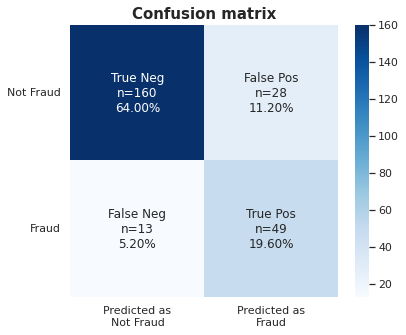

In [151]:
#confusion matrix
predictions = rs_xg.best_estimator_.predict(x_test)
cf_matrix = confusion_matrix(y_test, predictions)

#labels for the inside of heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['n={0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

#put them next line
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

#in array 2,2 cos the heatmap will be 2,2
labels = np.asarray(labels).reshape(2,2)

#class labeling
yticklabels=['Not Fraud','Fraud']
xticklabels=['Predicted as\nNot Fraud','Predicted as\nFraud']


# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(6,5))

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.set()
ax = sns.heatmap(cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

# Resize the labels.
ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

In [154]:
predictions = rs_xg.best_estimator_.predict(x_test)
print(classification_report(y_test, predictions, target_names=['Not Fraud',"Fraud"]))

              precision    recall  f1-score   support

   Not Fraud       0.92      0.85      0.89       188
       Fraud       0.64      0.79      0.71        62

    accuracy                           0.84       250
   macro avg       0.78      0.82      0.80       250
weighted avg       0.85      0.84      0.84       250



#### Feature Importance

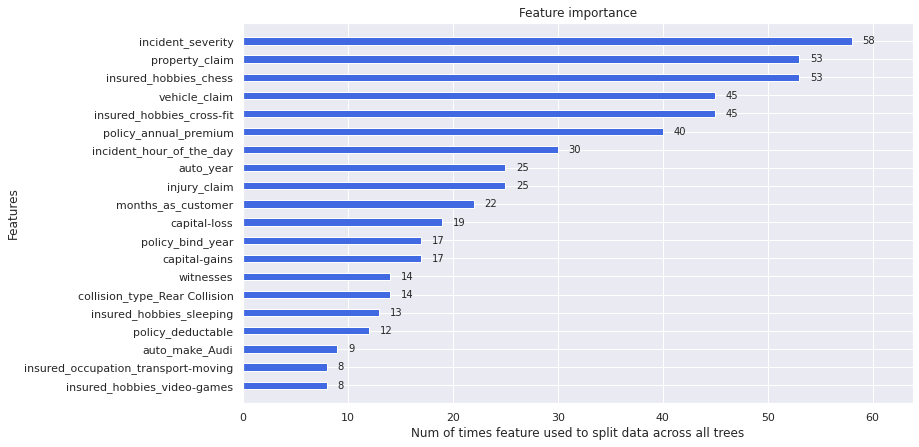

In [160]:
# plot feature importance

fig, ax = plt.subplots(figsize=(12, 7))
plot_importance(rs_xg.best_estimator_, importance_type='weight', 
                max_num_features=20, height=0.4, ax=ax, xlabel='Num of times feature used to split data across all trees',
               color='royalblue');

The figure summarizes the top 20 ranked by feature importance, based on weight. Drivers with hobbies such as chess, cross-fit seemed to be more prone to frauds. Incident severity and property claim are amongst the highest as well. Interaction terms such as premium and total claim amount, vehicle claim amount and incident severity were also top features by weight.

In [162]:
#Saving the model to pickle
import pickle
filename = 'insurance_fruad_model.pkl'
pickle.dump(rs_xg, open('insurance_fruad_model.pkl', 'wb'))

Index(['insured_occupation_armed-forces', 'insured_occupation_craft-repair',
       'insured_occupation_exec-managerial',
       'insured_occupation_farming-fishing',
       'insured_occupation_handlers-cleaners',
       'insured_occupation_machine-op-inspct',
       'insured_occupation_other-service',
       'insured_occupation_priv-house-serv',
       'insured_occupation_prof-specialty',
       'insured_occupation_protective-serv',
       ...
       'incident_severity', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_year',
       'policy_bind_year'],
      dtype='object', length=101)
